In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [10]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [11]:
df = pd.read_csv("data/daily_min_temp.csv", parse_dates=["Date"])
df['quarter'] = df.Date.dt.quarter
df = pd.get_dummies(df, columns=['quarter'])
df.set_index('Date', inplace=True)
df.head()

,Temp,quarter_1,quarter_2,quarter_3,quarter_4
Date,,,,,
1981-01-01,20.7,1,0,0,0
1981-01-02,17.9,1,0,0,0
1981-01-03,18.8,1,0,0,0
1981-01-04,14.6,1,0,0,0
1981-01-05,15.8,1,0,0,0


## Scalling membantu RNN

In [8]:
# df.Temp = df.Temp.transform(lambda x: (x - x.mean()) /x.std())

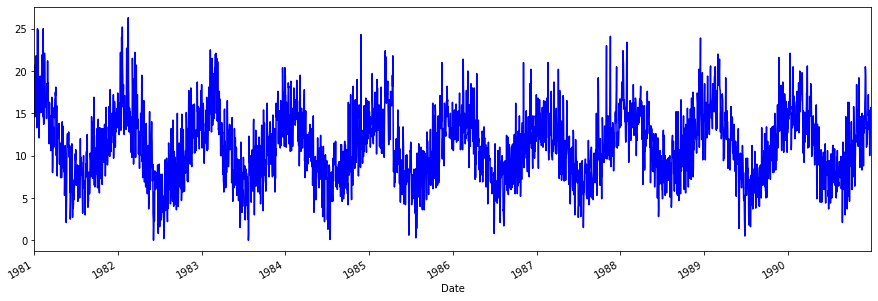

In [12]:
df.Temp.plot(figsize=(15, 5), color='b')

## Dataset Splitting

In [13]:
# X = df.Temp
# y = df.Temp

ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)
ts_train.shape, ts_test.shape

((2920, 5), (730, 5))

## Dataset & Dataloader

In [14]:
from jcopdl.utils.dataloader import TimeSeriesDataset
from torch.utils.data import DataLoader

In [34]:
seq_len = 21
bs = 32

train_set = TimeSeriesDataset(ts_train, "Temp", seq_len)
trainloader = DataLoader(train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test, "Temp", seq_len)
testloader = DataLoader(test_set, batch_size=bs)

(N, S, F): (139, 21, 5)
Note: last 0 data excluded

(N, S, F): (34, 21, 5)
Note: last 15 data excluded



## Arsitektur & Config

In [35]:
class GRU(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
        super().__init__()
        
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden
        

In [36]:
config = set_config({
    "input_size": train_set.n_feature,
    "seq_len": train_set.n_seq,
    "output_size": 1,
    "hidden_size": 64,
    "num_layers": 2,
    "dropout": 0
})

## Training Preparation -> MCOC

In [37]:
model = GRU(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model/multivar")

## Training

In [38]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost



Epoch     1
Train_cost  = 132.2557 | Test_cost  = 126.9209 | 




Epoch     2
Train_cost  = 114.3036 | Test_cost  = 109.4157 | 




Epoch     3
Train_cost  = 97.8955 | Test_cost  = 93.8110 | 




Epoch     4
Train_cost  = 83.7849 | Test_cost  = 81.4926 | 




Epoch     5
Train_cost  = 72.9847 | Test_cost  = 72.3853 | 




Epoch     6
Train_cost  = 64.9781 | Test_cost  = 65.3899 | 




Epoch     7
Train_cost  = 58.7246 | Test_cost  = 59.6509 | 




Epoch     8
Train_cost  = 53.5167 | Test_cost  = 54.6806 | 




Epoch     9
Train_cost  = 48.9694 | Test_cost  = 50.2479 | 




Epoch    10
Train_cost  = 44.9149 | Test_cost  = 46.2736 | 




Epoch    11
Train_cost  = 41.2981 | Test_cost  = 42.7282 | 




Epoch    12
Train_cost  = 38.0862 | Test_cost  = 39.5695 | 




Epoch    13
Train_cost  = 35.2361 | Test_cost  = 36.7550 | 




Epoch    14
Train_cost  = 32.7088 | Test_cost  = 34.2505 | 




Epoch    15
Train_cost  = 30.4722 | Test_cost  = 32.0267 | 




Epoch    16
Train_cost  = 28.4983 | Test_cost  = 30.0572 | 




Epoch    17
Train_cost  = 26.7616 | Test_cost  = 28.3180 | 




Epoch    18
Train_cost  = 25.2391 | Test_cost  = 26.7870 | 




Epoch    19
Train_cost  = 23.9092 | Test_cost  = 25.4437 | 




Epoch    20
Train_cost  = 22.7522 | Test_cost  = 24.2689 | 


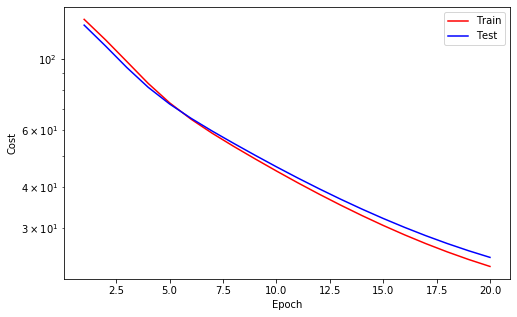



Epoch    21
Train_cost  = 21.7498 | Test_cost  = 23.2451 | 




Epoch    22
Train_cost  = 20.8850 | Test_cost  = 22.3559 | 




Epoch    23
Train_cost  = 20.1422 | Test_cost  = 21.5863 | 




Epoch    24
Train_cost  = 19.5068 | Test_cost  = 20.9222 | 




Epoch    25
Train_cost  = 18.9658 | Test_cost  = 20.3511 | 




Epoch    26
Train_cost  = 18.5071 | Test_cost  = 19.8614 | 




Epoch    27
Train_cost  = 18.1199 | Test_cost  = 19.4427 | 




Epoch    28
Train_cost  = 17.7944 | Test_cost  = 19.0857 | 




Epoch    29
Train_cost  = 17.5220 | Test_cost  = 18.7820 | 




Epoch    30
Train_cost  = 17.2947 | Test_cost  = 18.5242 | 




Epoch    31
Train_cost  = 17.1060 | Test_cost  = 18.3058 | 




Epoch    32
Train_cost  = 16.9497 | Test_cost  = 18.1210 | 




Epoch    33
Train_cost  = 16.8208 | Test_cost  = 17.9648 | 




Epoch    34
Train_cost  = 16.7147 | Test_cost  = 17.8330 | 




Epoch    35
Train_cost  = 16.6276 | Test_cost  = 17.7217 | 




Epoch    36
Train_cost  = 16.5563 | Test_cost  = 17.6278 | 




Epoch    37
Train_cost  = 16.4979 | Test_cost  = 17.5486 | 




Epoch    38
Train_cost  = 16.4501 | Test_cost  = 17.4816 | 




Epoch    39
Train_cost  = 16.4110 | Test_cost  = 17.4249 | 




Epoch    40
Train_cost  = 16.3789 | Test_cost  = 17.3768 | 


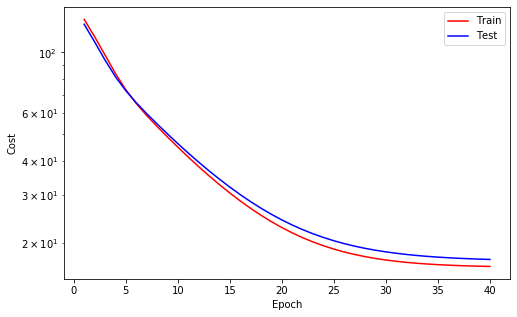



Epoch    41
Train_cost  = 16.3524 | Test_cost  = 17.3360 | 




Epoch    42
Train_cost  = 16.3305 | Test_cost  = 17.3012 | 




Epoch    43
Train_cost  = 16.3123 | Test_cost  = 17.2715 | 




Epoch    44
Train_cost  = 16.2969 | Test_cost  = 17.2459 | 




Epoch    45
Train_cost  = 16.2838 | Test_cost  = 17.2238 | 




Epoch    46
Train_cost  = 16.2725 | Test_cost  = 17.2046 | 




Epoch    47
Train_cost  = 16.2624 | Test_cost  = 17.1877 | 




Epoch    48
Train_cost  = 16.2534 | Test_cost  = 17.1728 | 




Epoch    49
Train_cost  = 16.2450 | Test_cost  = 17.1593 | 




Epoch    50
Train_cost  = 16.2371 | Test_cost  = 17.1470 | 




Epoch    51
Train_cost  = 16.2292 | Test_cost  = 17.1354 | 




Epoch    52
Train_cost  = 16.2211 | Test_cost  = 17.1241 | 




Epoch    53
Train_cost  = 16.2125 | Test_cost  = 17.1127 | 




Epoch    54
Train_cost  = 16.2029 | Test_cost  = 17.1005 | 




Epoch    55
Train_cost  = 16.1916 | Test_cost  = 17.0865 | 




Epoch    56
Train_cost  = 16.1773 | Test_cost  = 17.0695 | 




Epoch    57
Train_cost  = 16.1593 | Test_cost  = 17.0495 | 




Epoch    58
Train_cost  = 16.1372 | Test_cost  = 17.0239 | 




Epoch    59
Train_cost  = 16.1077 | Test_cost  = 16.9870 | 




Epoch    60
Train_cost  = 16.0636 | Test_cost  = 16.9292 | 


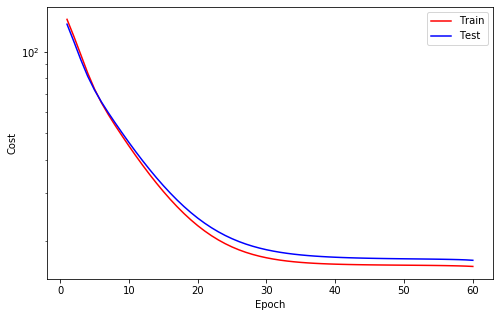



Epoch    61
Train_cost  = 15.9943 | Test_cost  = 16.8385 | 




Epoch    62
Train_cost  = 15.8847 | Test_cost  = 16.6989 | 




Epoch    63
Train_cost  = 15.7294 | Test_cost  = 16.5607 | 




Epoch    64
Train_cost  = 15.5858 | Test_cost  = 16.3918 | 




Epoch    65
Train_cost  = 15.3780 | Test_cost  = 16.0688 | 




Epoch    66
Train_cost  = 15.0417 | Test_cost  = 15.5831 | 




Epoch    67
Train_cost  = 14.4911 | Test_cost  = 14.7061 | 




Epoch    68
Train_cost  = 13.5080 | Test_cost  = 13.4473 | 




Epoch    69
Train_cost  = 12.3950 | Test_cost  = 12.6302 | 




Epoch    70
Train_cost  = 11.7131 | Test_cost  = 12.1698 | 




Epoch    71
Train_cost  = 11.2869 | Test_cost  = 11.5892 | 




Epoch    72
Train_cost  = 10.8062 | Test_cost  = 11.1152 | 




Epoch    73
Train_cost  = 10.4577 | Test_cost  = 10.7023 | 




Epoch    74
Train_cost  = 10.1128 | Test_cost  = 10.2874 | 




Epoch    75
Train_cost  = 9.7984 | Test_cost  = 9.9533 | 




Epoch    76
Train_cost  = 9.5194 | Test_cost  = 9.6370 | 




Epoch    77
Train_cost  = 9.2650 | Test_cost  = 9.3510 | 




Epoch    78
Train_cost  = 9.0362 | Test_cost  = 9.0907 | 




Epoch    79
Train_cost  = 8.8337 | Test_cost  = 8.8476 | 




Epoch    80
Train_cost  = 8.6468 | Test_cost  = 8.6306 | 


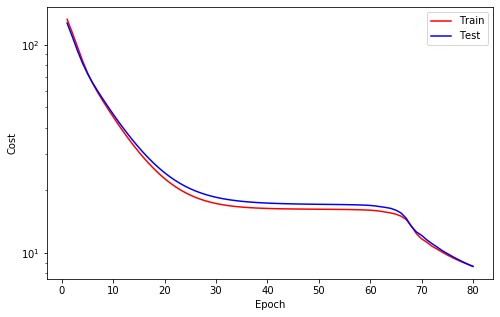



Epoch    81
Train_cost  = 8.4825 | Test_cost  = 8.4349 | 




Epoch    82
Train_cost  = 8.3330 | Test_cost  = 8.2574 | 




Epoch    83
Train_cost  = 8.1991 | Test_cost  = 8.0919 | 




Epoch    84
Train_cost  = 8.0744 | Test_cost  = 7.9381 | 




Epoch    85
Train_cost  = 7.9589 | Test_cost  = 7.7965 | 




Epoch    86
Train_cost  = 7.8514 | Test_cost  = 7.6638 | 




Epoch    87
Train_cost  = 7.7509 | Test_cost  = 7.5373 | 




Epoch    88
Train_cost  = 7.6561 | Test_cost  = 7.4178 | 




Epoch    89
Train_cost  = 7.5675 | Test_cost  = 7.3070 | 




Epoch    90
Train_cost  = 7.4850 | Test_cost  = 7.2025 | 




Epoch    91
Train_cost  = 7.4084 | Test_cost  = 7.1039 | 




Epoch    92
Train_cost  = 7.3367 | Test_cost  = 7.0120 | 




Epoch    93
Train_cost  = 7.2701 | Test_cost  = 6.9266 | 




Epoch    94
Train_cost  = 7.2079 | Test_cost  = 6.8464 | 




Epoch    95
Train_cost  = 7.1495 | Test_cost  = 6.7714 | 




Epoch    96
Train_cost  = 7.0945 | Test_cost  = 6.7013 | 




Epoch    97
Train_cost  = 7.0426 | Test_cost  = 6.6350 | 




Epoch    98
Train_cost  = 6.9934 | Test_cost  = 6.5723 | 




Epoch    99
Train_cost  = 6.9465 | Test_cost  = 6.5130 | 




Epoch   100
Train_cost  = 6.9019 | Test_cost  = 6.4566 | 


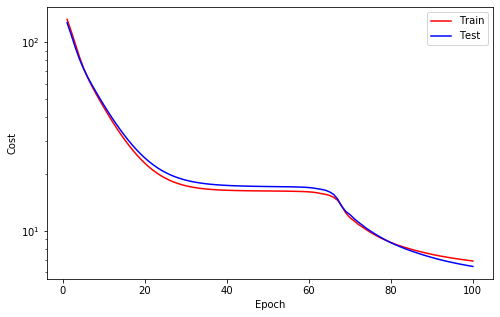



Epoch   101
Train_cost  = 6.8594 | Test_cost  = 6.4030 | 




Epoch   102
Train_cost  = 6.8188 | Test_cost  = 6.3522 | 




Epoch   103
Train_cost  = 6.7799 | Test_cost  = 6.3039 | 




Epoch   104
Train_cost  = 6.7427 | Test_cost  = 6.2582 | 




Epoch   105
Train_cost  = 6.7071 | Test_cost  = 6.2151 | 




Epoch   106
Train_cost  = 6.6731 | Test_cost  = 6.1739 | 




Epoch   107
Train_cost  = 6.6404 | Test_cost  = 6.1345 | 




Epoch   108
Train_cost  = 6.6091 | Test_cost  = 6.0965 | 




Epoch   109
Train_cost  = 6.5788 | Test_cost  = 6.0599 | 




Epoch   110
Train_cost  = 6.5498 | Test_cost  = 6.0247 | 




Epoch   111
Train_cost  = 6.5218 | Test_cost  = 5.9910 | 




Epoch   112
Train_cost  = 6.4948 | Test_cost  = 5.9585 | 




Epoch   113
Train_cost  = 6.4689 | Test_cost  = 5.9273 | 




Epoch   114
Train_cost  = 6.4440 | Test_cost  = 5.8974 | 




Epoch   115
Train_cost  = 6.4200 | Test_cost  = 5.8685 | 




Epoch   116
Train_cost  = 6.3969 | Test_cost  = 5.8407 | 




Epoch   117
Train_cost  = 6.3747 | Test_cost  = 5.8140 | 




Epoch   118
Train_cost  = 6.3533 | Test_cost  = 5.7882 | 




Epoch   119
Train_cost  = 6.3327 | Test_cost  = 5.7633 | 




Epoch   120
Train_cost  = 6.3128 | Test_cost  = 5.7394 | 


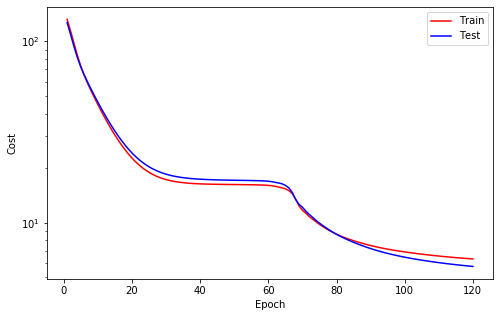



Epoch   121
Train_cost  = 6.2937 | Test_cost  = 5.7164 | 




Epoch   122
Train_cost  = 6.2753 | Test_cost  = 5.6943 | 




Epoch   123
Train_cost  = 6.2575 | Test_cost  = 5.6729 | 




Epoch   124
Train_cost  = 6.2404 | Test_cost  = 5.6524 | 




Epoch   125
Train_cost  = 6.2239 | Test_cost  = 5.6326 | 




Epoch   126
Train_cost  = 6.2080 | Test_cost  = 5.6137 | 




Epoch   127
Train_cost  = 6.1926 | Test_cost  = 5.5954 | 




Epoch   128
Train_cost  = 6.1777 | Test_cost  = 5.5779 | 




Epoch   129
Train_cost  = 6.1633 | Test_cost  = 5.5611 | 




Epoch   130
Train_cost  = 6.1493 | Test_cost  = 5.5450 | 




Epoch   131
Train_cost  = 6.1358 | Test_cost  = 5.5295 | 




Epoch   132
Train_cost  = 6.1226 | Test_cost  = 5.5146 | 




Epoch   133
Train_cost  = 6.1098 | Test_cost  = 5.5003 | 




Epoch   134
Train_cost  = 6.0974 | Test_cost  = 5.4864 | 




Epoch   135
Train_cost  = 6.0852 | Test_cost  = 5.4729 | 




Epoch   136
Train_cost  = 6.0733 | Test_cost  = 5.4599 | 




Epoch   137
Train_cost  = 6.0618 | Test_cost  = 5.4473 | 




Epoch   138
Train_cost  = 6.0504 | Test_cost  = 5.4349 | 




Epoch   139
Train_cost  = 6.0393 | Test_cost  = 5.4229 | 




Epoch   140
Train_cost  = 6.0284 | Test_cost  = 5.4111 | 


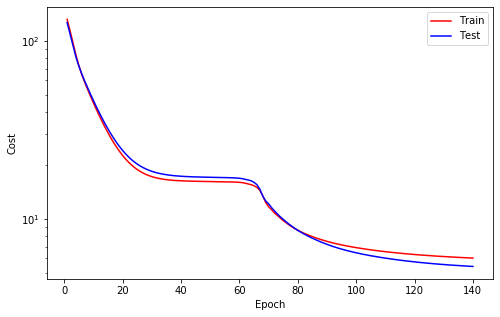



Epoch   141
Train_cost  = 6.0177 | Test_cost  = 5.3997 | 




Epoch   142
Train_cost  = 6.0072 | Test_cost  = 5.3886 | 




Epoch   143
Train_cost  = 5.9968 | Test_cost  = 5.3778 | 




Epoch   144
Train_cost  = 5.9867 | Test_cost  = 5.3675 | 




Epoch   145
Train_cost  = 5.9767 | Test_cost  = 5.3576 | 




Epoch   146
Train_cost  = 5.9669 | Test_cost  = 5.3481 | 




Epoch   147
Train_cost  = 5.9572 | Test_cost  = 5.3390 | 




Epoch   148
Train_cost  = 5.9477 | Test_cost  = 5.3302 | 




Epoch   149
Train_cost  = 5.9384 | Test_cost  = 5.3218 | 




Epoch   150
Train_cost  = 5.9292 | Test_cost  = 5.3136 | 




Epoch   151
Train_cost  = 5.9201 | Test_cost  = 5.3058 | 




Epoch   152
Train_cost  = 5.9112 | Test_cost  = 5.2982 | 




Epoch   153
Train_cost  = 5.9024 | Test_cost  = 5.2909 | 




Epoch   154
Train_cost  = 5.8937 | Test_cost  = 5.2838 | 




Epoch   155
Train_cost  = 5.8852 | Test_cost  = 5.2769 | 




Epoch   156
Train_cost  = 5.8767 | Test_cost  = 5.2702 | 




Epoch   157
Train_cost  = 5.8684 | Test_cost  = 5.2638 | 




Epoch   158
Train_cost  = 5.8602 | Test_cost  = 5.2575 | 




Epoch   159
Train_cost  = 5.8522 | Test_cost  = 5.2515 | 




Epoch   160
Train_cost  = 5.8442 | Test_cost  = 5.2457 | 


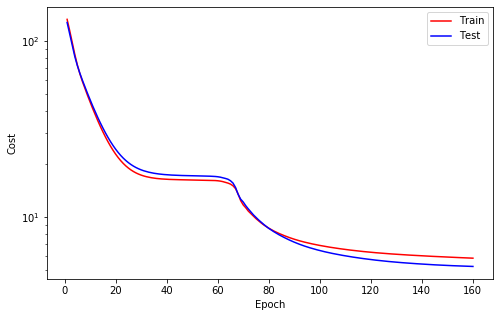



Epoch   161
Train_cost  = 5.8363 | Test_cost  = 5.2401 | 




Epoch   162
Train_cost  = 5.8286 | Test_cost  = 5.2347 | 




Epoch   163
Train_cost  = 5.8210 | Test_cost  = 5.2295 | 




Epoch   164
Train_cost  = 5.8134 | Test_cost  = 5.2244 | 




Epoch   165
Train_cost  = 5.8060 | Test_cost  = 5.2196 | 




Epoch   166
Train_cost  = 5.7986 | Test_cost  = 5.2150 | 




Epoch   167
Train_cost  = 5.7914 | Test_cost  = 5.2106 | 




Epoch   168
Train_cost  = 5.7842 | Test_cost  = 5.2065 | 




Epoch   169
Train_cost  = 5.7772 | Test_cost  = 5.2026 | 




Epoch   170
Train_cost  = 5.7702 | Test_cost  = 5.1990 | 




Epoch   171
Train_cost  = 5.7633 | Test_cost  = 5.1957 | 




Epoch   172
Train_cost  = 5.7565 | Test_cost  = 5.1926 | 




Epoch   173
Train_cost  = 5.7497 | Test_cost  = 5.1898 | 




Epoch   174
Train_cost  = 5.7430 | Test_cost  = 5.1871 | 




Epoch   175
Train_cost  = 5.7364 | Test_cost  = 5.1847 | 




Epoch   176
Train_cost  = 5.7298 | Test_cost  = 5.1824 | 




Epoch   177
Train_cost  = 5.7233 | Test_cost  = 5.1803 | 




Epoch   178
Train_cost  = 5.7168 | Test_cost  = 5.1783 | 




Epoch   179
Train_cost  = 5.7104 | Test_cost  = 5.1765 | 




Epoch   180
Train_cost  = 5.7040 | Test_cost  = 5.1748 | 


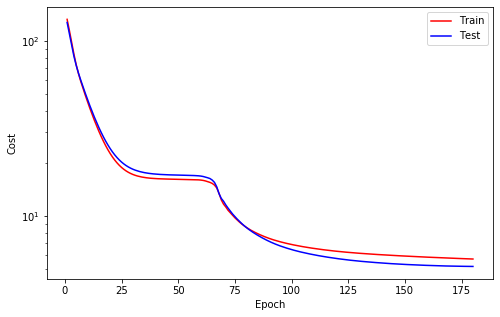



Epoch   181
Train_cost  = 5.6977 | Test_cost  = 5.1733 | 




Epoch   182
Train_cost  = 5.6914 | Test_cost  = 5.1720 | 




Epoch   183
Train_cost  = 5.6852 | Test_cost  = 5.1708 | 




Epoch   184
Train_cost  = 5.6790 | Test_cost  = 5.1698 | 




Epoch   185
Train_cost  = 5.6729 | Test_cost  = 5.1690 | 




Epoch   186
Train_cost  = 5.6667 | Test_cost  = 5.1684 | 




Epoch   187
Train_cost  = 5.6606 | Test_cost  = 5.1679 | 




Epoch   188
Train_cost  = 5.6546 | Test_cost  = 5.1676 | 




Epoch   189
Train_cost  = 5.6485 | Test_cost  = 5.1676 | 




Epoch   190
Train_cost  = 5.6425 | Test_cost  = 5.1677 | 
==> EarlyStop patience =  1 | Best test_cost: 5.1676




Epoch   191
Train_cost  = 5.6365 | Test_cost  = 5.1681 | 
==> EarlyStop patience =  2 | Best test_cost: 5.1676




Epoch   192
Train_cost  = 5.6306 | Test_cost  = 5.1687 | 
==> EarlyStop patience =  3 | Best test_cost: 5.1676




Epoch   193
Train_cost  = 5.6247 | Test_cost  = 5.1695 | 
==> EarlyStop patience =  4 | Best test_cost: 5.1676




Epoch   194
Train_cost  = 5.6188 | Test_cost  = 5.1705 | 
==> EarlyStop patience =  5 | Best test_cost: 5.1676
==> Execute Early Stopping at epoch: 194 | Best test_cost: 5.1676
==> Best model is saved at model/multivar


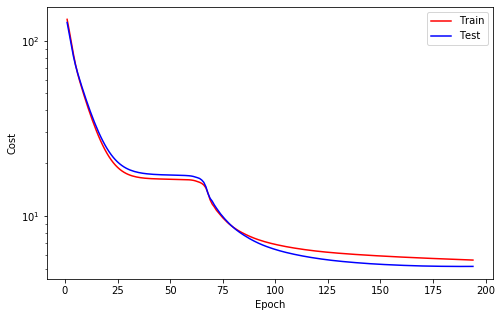

In [39]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

## Sanity Check

In [40]:
from luwiji.rnn import illustration

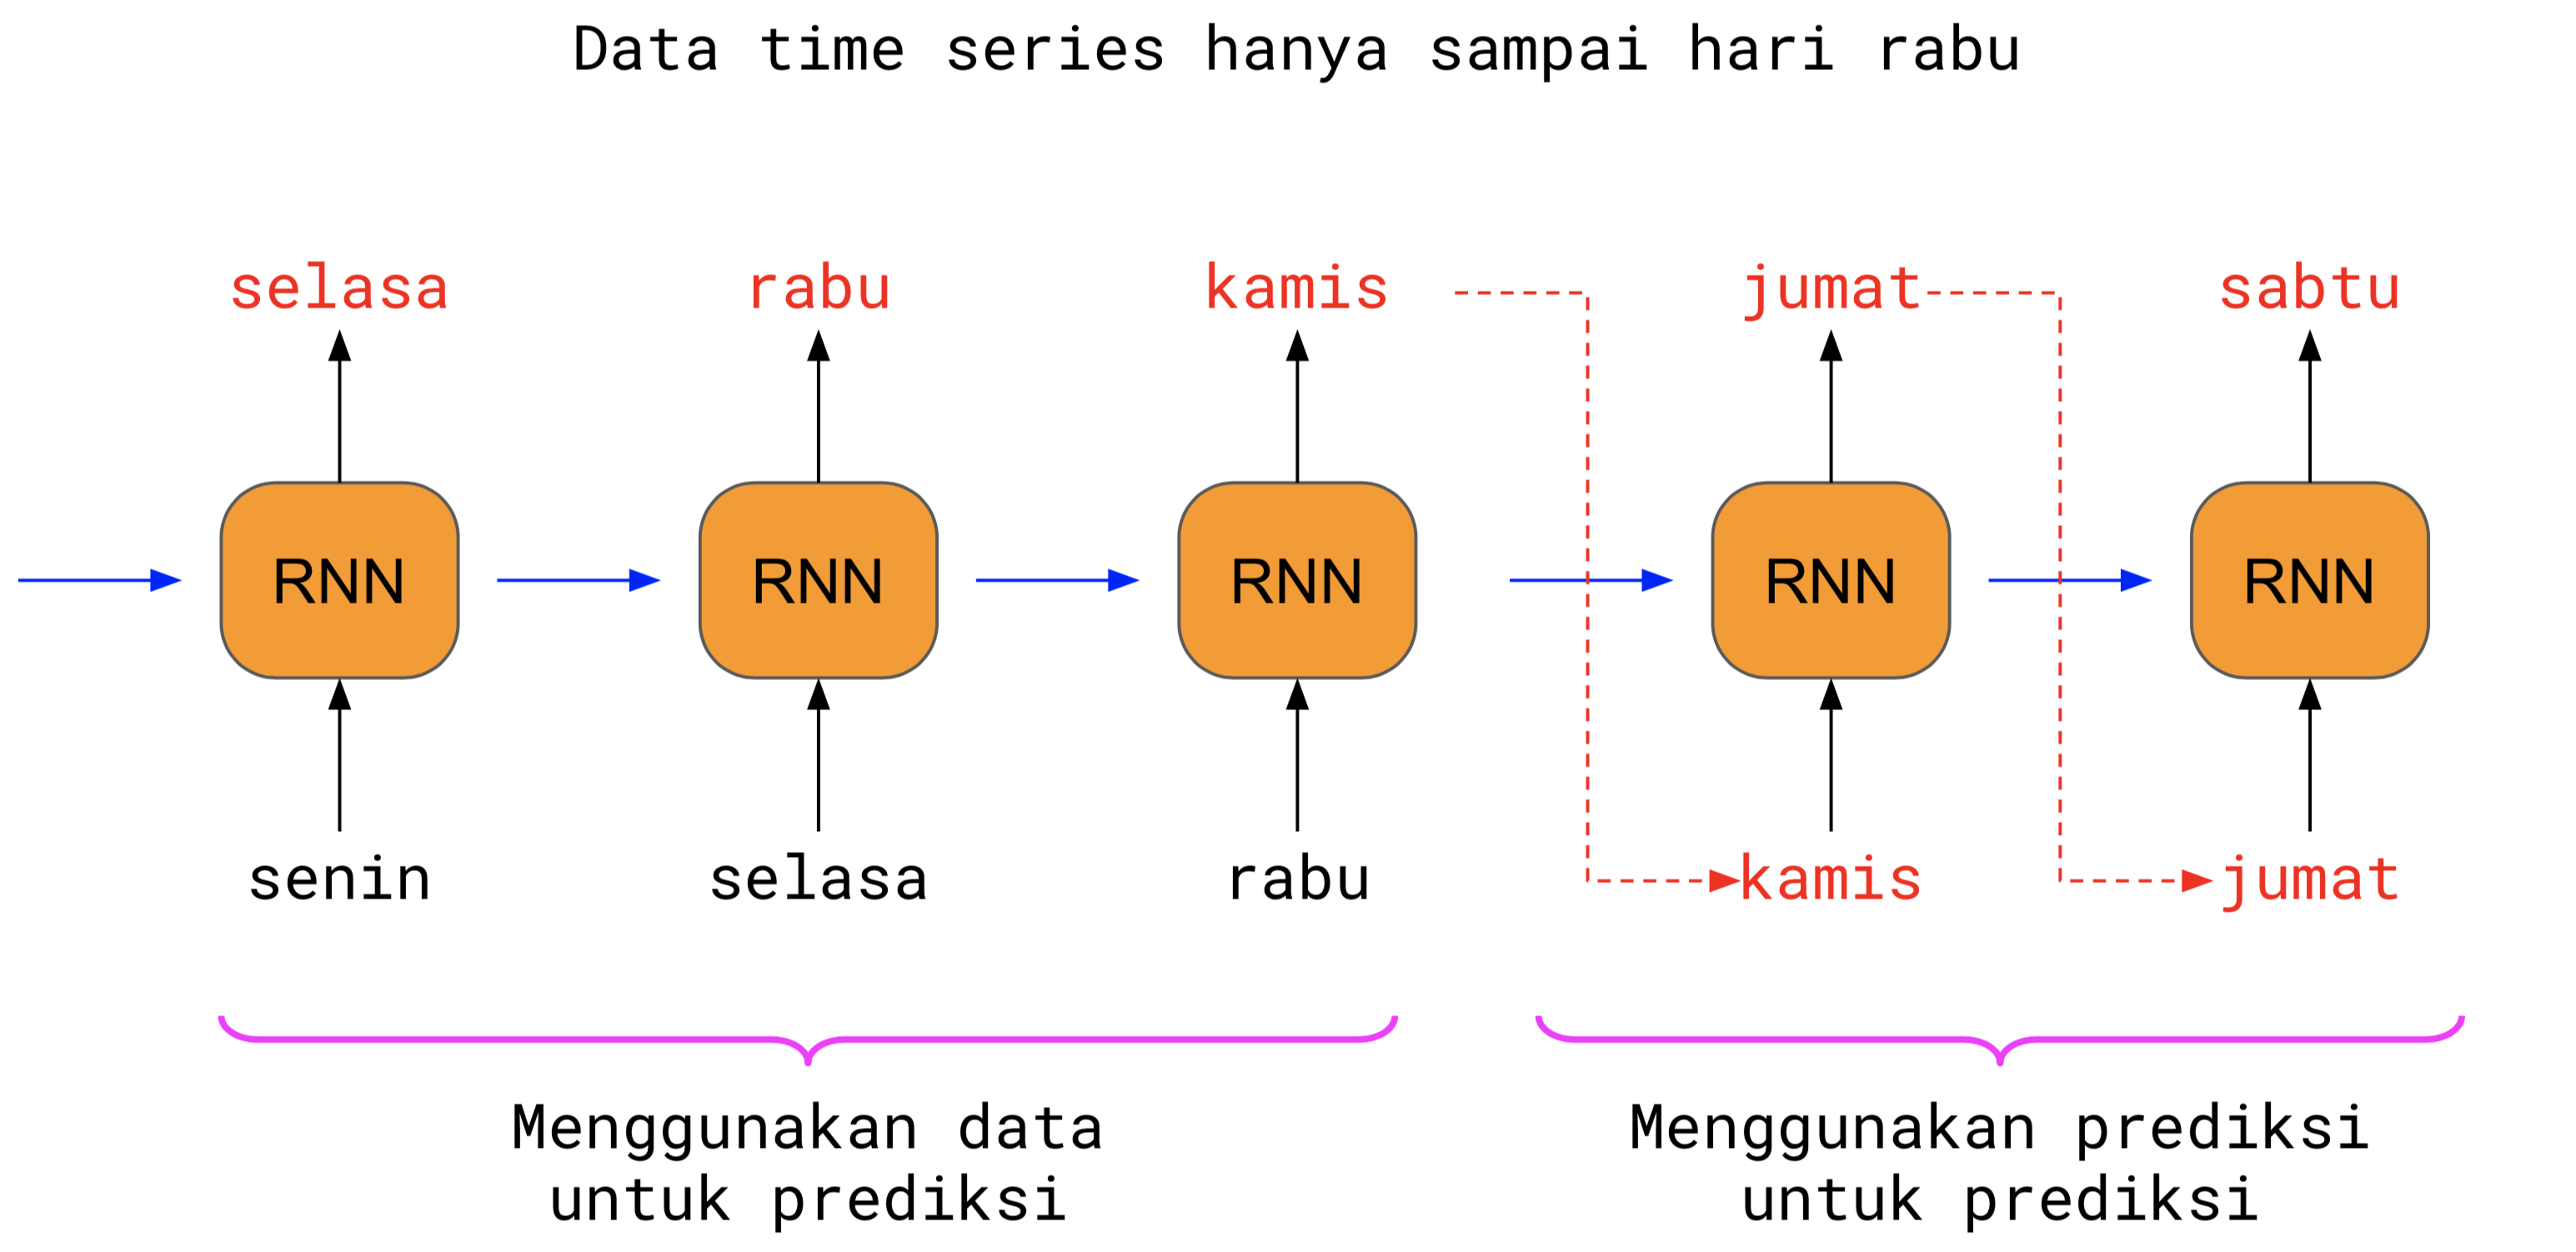

In [41]:
illustration.forecast

In [42]:
from utils import data4pred, pred4pred

In [43]:
train_forecast_set = TimeSeriesDataset(ts_train, "Temp", 1)
trainforecastloader = DataLoader(train_forecast_set)
test_forecast_set = TimeSeriesDataset(ts_test, "Temp", 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (2919, 1, 5)
Note: last 0 data excluded

(N, S, F): (729, 1, 5)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

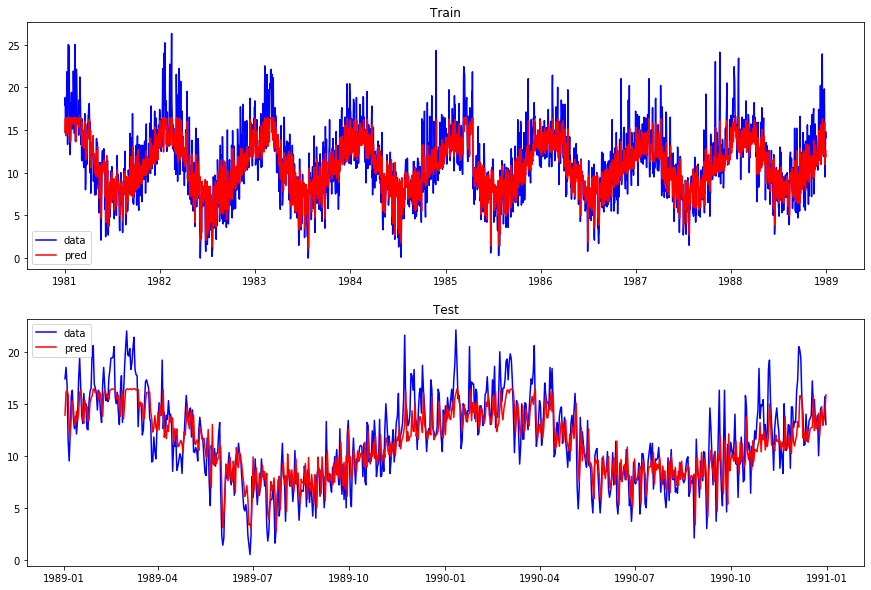

In [44]:
plt.figure(figsize=(15, 10))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")

Text(0.5, 1.0, 'test')

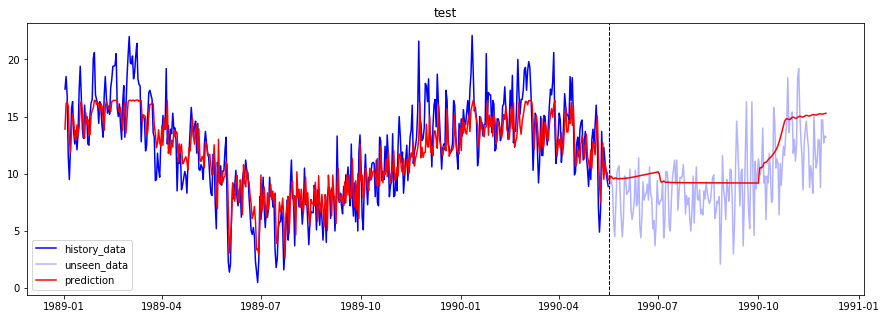

In [45]:
#Pred 4 pred
plt.figure(figsize=(15, 5))
pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title("test")

## More on RNN

In [46]:
from luwiji.rnn import illustration

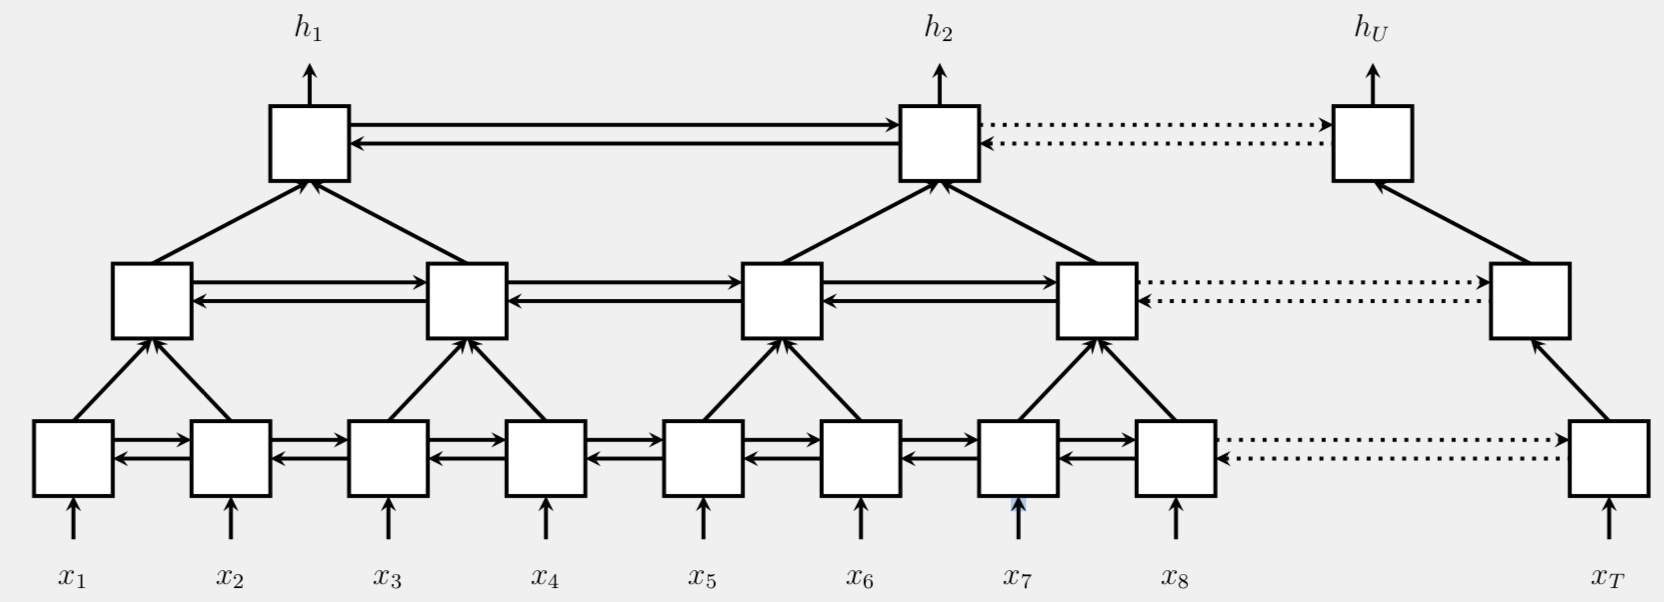

In [47]:
illustration.pyramid_blstm

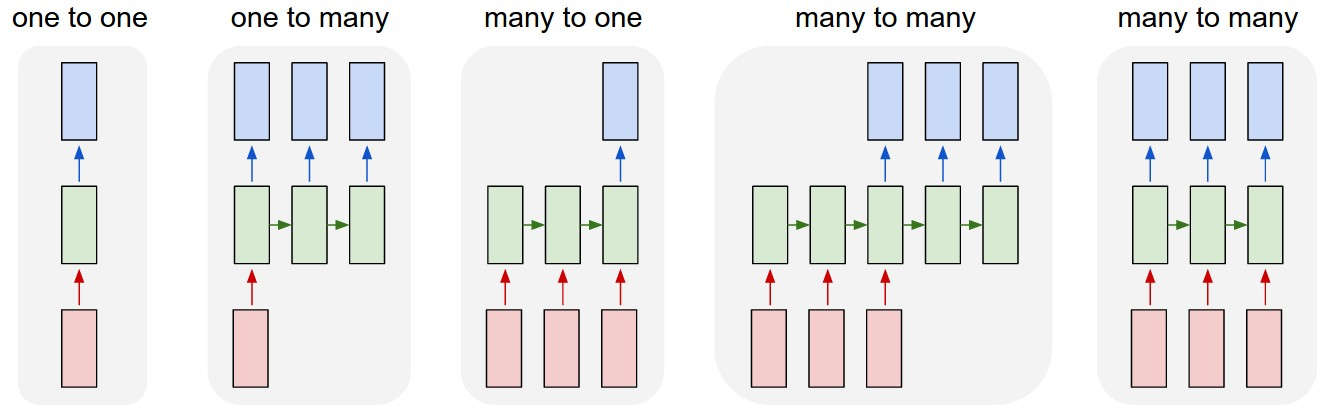

In [48]:
illustration.sequence_model

- one to one (fixed input and output):
    - Image classification
- one to many (fixed input and sequence output)
    - Image captioning
- many to one (sequence input and fixed output)
    - Sentiment analysis
- many to many (sequence input and sequence output)
    - machine translation
- synce many to many (seqeunce input and sequence output)
    - rame level video classification
    
check this out
http://karpathy.github.io/2015/05/21/rnn-effectiveness/